In [40]:
!pip install contractions

In [41]:
# librería para manejar las flexiones gramaticales en el idioma inglés.
!pip install inflect
# Manejo de gráficas
!pip install scikit-plot
# Pasar números a palabras
!pip install num2words
!pip install pandas-profiling imbalanced-learn scikit-learn==1.2.2 joblib

In [42]:
# librería Natural Language Toolkit, usada para trabajar con textos
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [43]:
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
# ¿Cuales son esas palabras vacías?

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
# ¿Qué es el lema de una palabra? ¿Qué tan dificil puede ser obtenerlo, piensa en el caso en que tuvieras que escribir la función que realiza esta tarea?
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [45]:
# Instalación de librerias
import pandas as pd
import numpy as np
#import sys
#!{sys.executable} -m pip install pandas-profiling
#!{sys.executable} -m pip install --upgrade joblib
#!{sys.executable} -m pip install --upgrade scikit-learn

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import BaseEstimator, ClassifierMixin

from scipy import stats as st

from num2words import num2words

import matplotlib.pyplot as plt

In [46]:
# Uso de la libreria pandas para la lectura de archivos
data=pd.read_csv('/content/sample_data/fake_news_spanish.csv', sep=';', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos
data_t=data
data_t

# Cargar los datos del test
data_test=pd.read_csv('/content/sample_data/fake_news_test.csv', delimiter=';', encoding = 'utf-8')

In [47]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  int64 
 2   Titulo       57047 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


In [48]:
textos = data_t.copy()

# Mirar primero la distribución de noticias: 0 = falsa, 1 = verídica
print(textos["Label"].value_counts(normalize=True))

textos['Conteo'] = [len(x) for x in textos['Descripcion']]
textos['Moda'] = [st.mode([len(x) for x in i.split(' ')])[0] for i in textos['Descripcion']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Descripcion']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Descripcion']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
textos.describe()

print(textos)

Label
1    0.581077
0    0.418923
Name: proportion, dtype: float64
       ID  Label                                             Titulo  \
0      ID      1  'The Guardian' va con Sánchez: 'Europa necesit...   
1      ID      0  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2      ID      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3      ID      1  Iglesias alienta a Yolanda Díaz, ERC y EH Bild...   
4      ID      0  Puigdemont: 'No sería ninguna tragedia una rep...   
...    ..    ...                                                ...   
57058  ID      1  El Defensor del Pueblo reclama a la Comunidad ...   
57059  ID      0  El EQUO plantea ceder la presidencia de la Com...   
57060  ID      1  Alberto Garzón: 'Que los Borbones son unos lad...   
57061  ID      1  Vox exige entrar en el Gobierno de Castilla y ...   
57062  ID      1  Unas 300 personas protestan contra la visita d...   

                                             Descripcion       Fecha  Conteo  \


In [49]:
textos

,ID,Label,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,218,2,13,1
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,3251,2,17,1
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,169,2,13,2
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,133,3,15,2
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,242,2,14,1
...,...,...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021,244,2,12,1
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020,314,3,11,1
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018,70,2,11,2
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022,232,2,12,1


In [50]:
# Cargar stopwords en español
from nltk.corpus import stopwords
import re
import pandas as pd
from num2words import num2words
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    # Convertir a string por seguridad
    texto = str(texto)

    # Eliminar URLs y menciones
    texto = re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+', '', texto, flags=re.MULTILINE)

    # Eliminar caracteres especiales excepto letras, números y espacios
    texto = re.sub(r'[^\w\sáéíóúñÁÉÍÓÚÑ]', '', texto)

    # Eliminar números adjuntos a palabras (ej: covid19)
    texto = re.sub(r'\b\d+[a-z]+\b|\b[a-z]+\d+\b', '', texto)

    # Eliminar espacios múltiples
    return re.sub(r'\s+', ' ', texto).strip()

def preprocessing(texto):
    if pd.isna(texto):
        return ""

    # Aplicar limpieza profunda
    texto = limpiar_texto(texto)

    # Pasar a minúsculas
    texto = texto.lower()

    # Tokenización mejorada
    palabras = word_tokenize(texto, language='spanish')

    palabras_proc = []
    for palabra in palabras:
        # Manejar números (incluyendo decimales)
        if re.match(r'^[\d,\.]+$', palabra):
            try:
                # Convertir a float si tiene decimales
                num = float(palabra.replace(',', '.'))
                palabra_texto = num2words(num, lang='es')
                palabras_proc.append(palabra_texto)
            except:
                continue
        elif palabra not in stop_words and len(palabra) > 1:  # Filtrar stopwords y caracteres sueltos
            palabras_proc.append(palabra)

    return " ".join(palabras_proc)

# Aplicar limpieza a Titulo y Descripcion (versión mejorada)
data_t["Titulo"] = data_t["Titulo"].fillna("").apply(preprocessing)
data_t["Descripcion"] = data_t["Descripcion"].fillna("").apply(preprocessing)

# Aplicar doble limpieza para garantizar consistencia (como en el original)
data_t["Titulo"] = data_t["Titulo"].apply(preprocessing)
data_t["Descripcion"] = data_t["Descripcion"].apply(preprocessing)

data_t.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,the guardian va sánchez europa necesita apuest...,diario británico publicó pasado jueves editori...,02/06/2023
1,ID,0,revelan gobierno negocio liberación mireles ca...,revelan gobierno negocio liberación mireles ca...,01/10/2023
2,ID,1,ahora nunca joan fuster estatuto valenciano cu...,valencianismo convoca castelló fiesta grande c...,25/04/2022
3,ID,1,iglesias alienta yolanda díaz erc eh bildu neg...,política igual negociar empresarios negociar g...,03/01/2022
4,ID,0,puigdemont ninguna tragedia repetición elecciones,entrevista punt avui líder jxcat desdramatizad...,09/03/2018


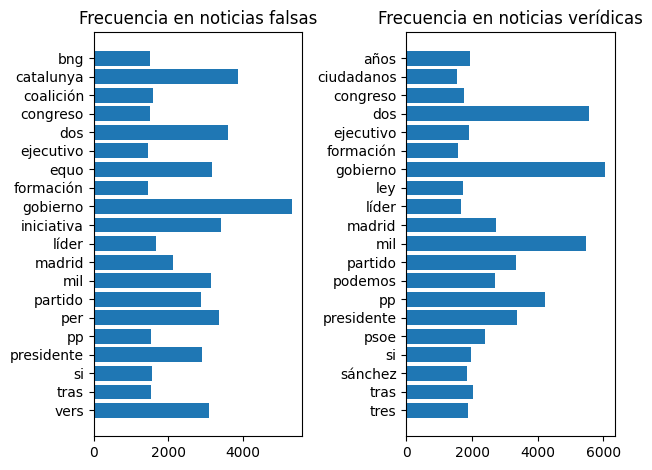

In [51]:
from collections import Counter

def palabras_frecuentes(textos, top_n=20):
    vectorizer = CountVectorizer(stop_words=list(stop_words), max_features=top_n)
    X = vectorizer.fit_transform(textos)
    palabras = vectorizer.get_feature_names_out()
    frecuencias = X.toarray().sum(axis=0)
    return list(zip(palabras, frecuencias))

# Obtener palabras más frecuentes
palabras_falsas = palabras_frecuentes(data_t[data_t["Label"] == 0]["Descripcion"])
palabras_verdaderas = palabras_frecuentes(data_t[data_t["Label"] == 1]["Descripcion"])

# Graficar
fig, ax = plt.subplots(1, 2)
ax[0].barh([p[0] for p in palabras_falsas], [p[1] for p in palabras_falsas])
ax[0].set_title("Frecuencia en noticias falsas")
ax[0].invert_yaxis()

ax[1].barh([p[0] for p in palabras_verdaderas], [p[1] for p in palabras_verdaderas])
ax[1].set_title("Frecuencia en noticias verídicas")
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [54]:
data_t["texto"] = data_t["Titulo"] + " " + data_t["Descripcion"]
data_t.head()
def analizar_palabras_clave(dataframe, col_texto, label, top_n=15, ngram_range=(1,2)):
    """
    Analiza las palabras y bigramas más frecuentes para una clase específica.

    Args:
        dataframe: DataFrame con los datos
        col_texto: Nombre de la columna con el texto procesado
        label: 0 (fake news) o 1 (noticias reales)
        top_n: Número de términos a mostrar
        ngram_range: Rango de n-gramas a considerar (1,2) para unigramas y bigramas
    """
    # Filtrar por clase y convertir a lista de textos
    textos = dataframe[dataframe["Label"] == label][col_texto].tolist()

    # Vectorizar considerando unigramas y bigramas
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=top_n*2)
    X = vectorizer.fit_transform(textos)

    # Crear DataFrame con frecuencias
    frecuencias = pd.DataFrame({
        "término": vectorizer.get_feature_names_out(),
        "frecuencia": X.sum(axis=0).tolist()[0]
    })

    # Filtrar y ordenar
    resultados = frecuencias.sort_values("frecuencia", ascending=False).head(top_n)

    # Formatear resultados
    print(f"\n=== TÉRMINOS CLAVE PARA CLASE {label} ({'FAKE NEWS' if label==0 else 'NOTICIAS REALES'}) ===")
    print(resultados.set_index("término").to_markdown())
    return resultados

# Ejecutar análisis para ambas clases
fake_terms = analizar_palabras_clave(data_t, "texto", 0)
real_terms = analizar_palabras_clave(data_t, "texto", 1)


=== TÉRMINOS CLAVE PARA CLASE 0 (FAKE NEWS) ===
| término         |   frecuencia |
|:----------------|-------------:|
| gobierno        |         8308 |
| catalunya       |         6725 |
| per             |         5914 |
| iniciativa      |         5900 |
| vers per        |         5550 |
| vers            |         5550 |
| iniciativa vers |         5539 |
| per catalunya   |         5517 |
| equo            |         5252 |
| dos             |         4639 |
| mil             |         4084 |
| madrid          |         3497 |
| partido         |         3289 |
| presidente      |         3210 |
| coalición       |         3106 |

=== TÉRMINOS CLAVE PARA CLASE 1 (NOTICIAS REALES) ===
| término    |   frecuencia |
|:-----------|-------------:|
| gobierno   |        10028 |
| pp         |         7884 |
| dos        |         7319 |
| mil        |         7183 |
| podemos    |         4746 |
| madrid     |         4683 |
| sánchez    |         4651 |
| psoe       |         4646 |
|

In [55]:
# Unir título y descripcion para tener todas las palabras clave que tal vez una tenga y la otra no
data_t["texto"] = data_t["Titulo"] + " " + data_t["Descripcion"]
data_test["texto"] = data_test["Titulo"].fillna("") + " " + data_test["Descripcion"].fillna("")

# Vectorización con TF-IDF al ser mejor para ML
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(data_t["texto"])
X_test = vectorizer.transform(data_test["texto"])

# Variable objetivo
y_train = data_t["Label"]

# Mostrar dimensiones
X_train.shape, X_test.shape

((57063, 5000), (1000, 5000))

In [56]:
# Dividir datos en entrenamiento y validación
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Definir algoritmos a usar: Regresión Logística y Naive Bayes -> Alejandra
algoritmos = {
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Entrenar y evaluar
resultados = {}
for nombre, algo in algoritmos.items():
    algo.fit(X_train_split, y_train_split)
    y_pred = algo.predict(X_val)
    reporte = classification_report(y_val, y_pred, output_dict=True)
    resultados[nombre] = {
        'accuracy': reporte['accuracy'],
        'precision_0': reporte['0']['precision'],
        'recall_1': reporte['1']['recall'],
        'f1_macro': reporte['macro avg']['f1-score']
    }

df_resultados = pd.DataFrame(resultados).T
print(df_resultados)

                     accuracy  precision_0  recall_1  f1_macro
Regresión Logística  0.898975     0.940043  0.962301  0.894086
Naive Bayes          0.864015     0.957560  0.977139  0.853578
Random Forest        0.928678     0.946956  0.964118  0.926086


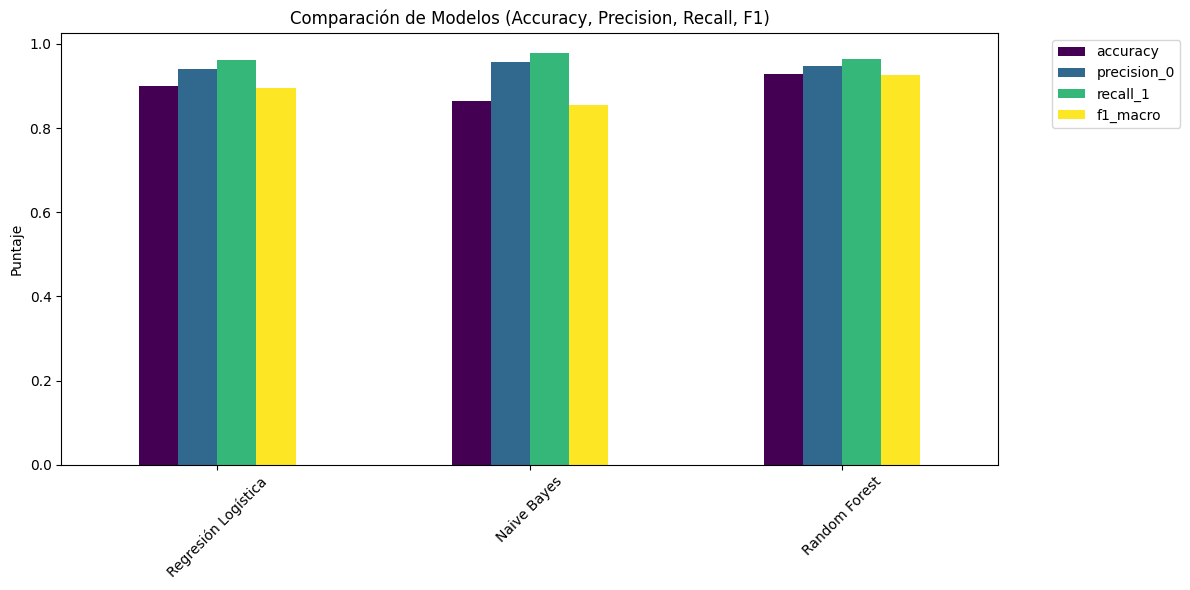

In [57]:
# Gráfico de barras comparativo
df_resultados.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Comparación de Modelos (Accuracy, Precision, Recall, F1)')
plt.xticks(rotation=45)
plt.ylabel('Puntaje')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [58]:
# Entrenar el modelo final con el mejor algoritmo
modelo_final = LogisticRegression(max_iter=1000)
modelo_final.fit(X_train, y_train)

# Predecir en los datos de prueba
y_test_pred = modelo_final.predict(X_test)

# Agregar predicciones al dataset
data_test["Label"] = y_test_pred

# Guardar el archivo final
output_path = "fake_news_test_predicted.csv"
data_test.to_csv(output_path, index=False, sep=';')

print(f"Archivo generado: {output_path}")

Archivo generado: fake_news_test_predicted.csv


In [59]:

predicciones = pd.read_csv('/content/fake_news_test_predicted.csv', sep=';')
predicciones.head()

,ID,Titulo,Descripcion,Fecha,texto,Label
0,ID,La mesa del congreso censura un encuentro inte...,"Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...",30/10/2018,La mesa del congreso censura un encuentro inte...,0
1,ID,La brecha digital que dificulta el acceso de a...,No es la primera vez que los ciudadanos vulner...,15/03/2023,La brecha digital que dificulta el acceso de a...,1
2,ID,PP apremia al EQUO a presentar una propuesta d...,El partido morado reprocha que los socialistas...,01/07/2019,PP apremia al EQUO a presentar una propuesta d...,0
3,ID,De soberano garante de la democracia a rey cor...,"La renuncia de Felipe VI a su herencia, proced...",16/03/2020,De soberano garante de la democracia a rey cor...,1
4,ID,El Gobierno aprobará este martes detraer los b...,El Ejecutivo también prorrogará la suspensión ...,13/09/2021,El Gobierno aprobará este martes detraer los b...,1
